### Transfer learning on Intel Image dataset (frozen vs fine-tuned MobileNetV2)

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.random.set_seed(42)

In [13]:
data_dir = 'Data/Intel Image Data/seg_train/seg_train'
img_size = (160, 160)
batch_size = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    'Data/Intel Image Data/seg_test/seg_test',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [15]:
# ----- Model 1: Frozen MobileNetV2 encoder (Sequential) -----
base_model_frozen = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet',
 )
base_model_frozen.trainable = False

model_frozen = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_size + (3,)),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    # Frozen encoder; keep BN in inference mode (moving stats not updated)
    tf.keras.layers.Lambda(lambda t: base_model_frozen(t, training=False)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model_frozen.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
 )
model_frozen.summary()

/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/.conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 5, 5, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,686 (30.02 KB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_frozen = model_frozen.fit(train_ds,
                                     epochs=5,
                                     validation_data=val_ds)
eval_frozen = model_frozen.evaluate(val_ds)
print('Frozen encoder val loss/acc:', eval_frozen)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7357 - loss: 0.7207 - val_accuracy: 0.8733 - val_loss: 0.3317
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8809 - loss: 0.3320 - val_accuracy: 0.8867 - val_loss: 0.3009
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8931 - loss: 0.2931 - val_accuracy: 0.8850 - val_loss: 0.3044
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8947 - loss: 0.2847 - val_accuracy: 0.8883 - val_loss: 0.2782
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9000 - loss: 0.2652 - val_accuracy: 0.8933 - val_loss: 0.2923
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.3001
Frozen encoder val loss/acc: [0.2922629415988922, 0.8933333158493042]


In [17]:
# ----- Model 2: Separate model for fine-tuning (Sequential) -----
base_model_ft = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet',
 )
base_model_ft.trainable = True

# Freeze most of the encoder; fine-tune only the last ~30 layers
fine_tune_at = len(base_model_ft.layers) - 30
for layer in base_model_ft.layers[:fine_tune_at]:
    layer.trainable = False

model_ft = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=img_size + (3,)),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    # Often more stable to not update BN moving stats while fine-tuning
    tf.keras.layers.Lambda(lambda t: base_model_ft(t, training=False)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
 )

history_ft = model_ft.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
 )
eval_ft = model_ft.evaluate(val_ds)
print('Fine-tuned val loss/acc:', eval_ft)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.4362 - loss: 1.5171 - val_accuracy: 0.7933 - val_loss: 0.6367
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8127 - loss: 0.5605 - val_accuracy: 0.8500 - val_loss: 0.4558
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8451 - loss: 0.4468 - val_accuracy: 0.8667 - val_loss: 0.3921
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8613 - loss: 0.3927 - val_accuracy: 0.8700 - val_loss: 0.3617
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8718 - loss: 0.3648 - val_accuracy: 0.8833 - val_loss: 0.3412
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8699 - loss: 0.3692
Fine-tuned val loss/acc: [0.34120261669158936, 0.8833333253860474]


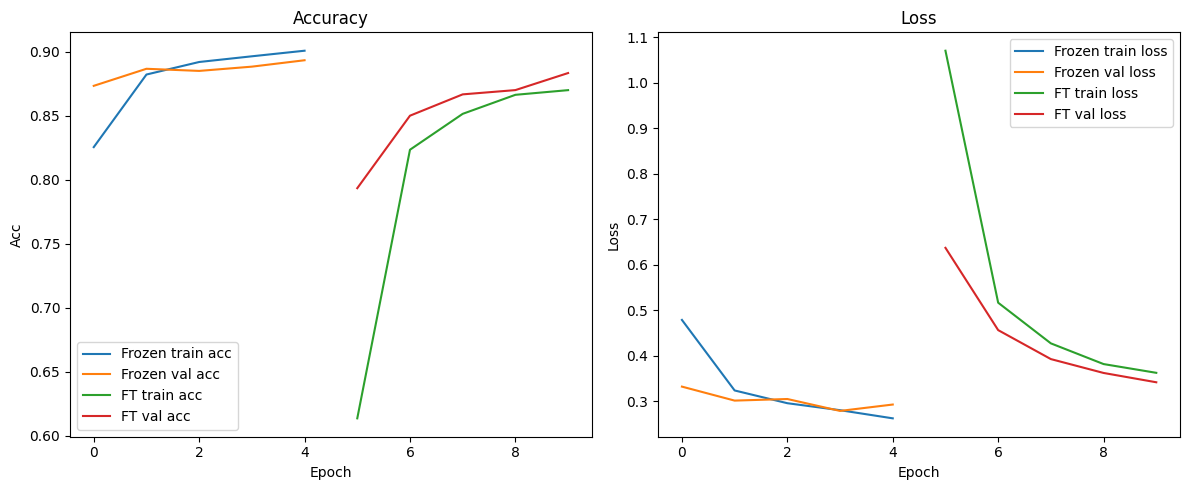

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_frozen.history['accuracy'], label='Frozen train acc')
plt.plot(history_frozen.history['val_accuracy'], label='Frozen val acc')
plt.plot([None]*len(history_frozen.history['accuracy']) + history_ft.history['accuracy'], label='FT train acc')
plt.plot([None]*len(history_frozen.history['val_accuracy']) + history_ft.history['val_accuracy'], label='FT val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_frozen.history['loss'], label='Frozen train loss')
plt.plot(history_frozen.history['val_loss'], label='Frozen val loss')
plt.plot([None]*len(history_frozen.history['loss']) + history_ft.history['loss'], label='FT train loss')
plt.plot([None]*len(history_frozen.history['val_loss']) + history_ft.history['val_loss'], label='FT val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()